<a href="https://colab.research.google.com/github/HONG-JU-OH/Bitcoin-Prediction-Project/blob/main/GRU%20%EB%AA%A8%EB%8D%B8%20_%20%EB%B9%84%ED%8A%B8%EC%BD%94%EC%9D%B8_%EC%98%88%EC%B8%A1_%ED%94%84%EB%A1%9C%EA%B7%B8%EB%9E%A8_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.2018년부터 2022년 데이터를 학습한후 2023년 예측하기

In [ ]:
!pip install finance-datareader # FinanceDataReader에서 데이터를 불러오기 위해 FinanceDataReader를 설치하는 과정

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install datetime

In [ ]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from sklearn.metrics import r2_score

# 데이터 불러오기
start_date = "2018-01-01"
end_date = "2023-12-31"  #22.12.31 원래 데이터
ticker = "BTC/KRW"  # 한국거래소에서 비트코인을 가격 데이터 가져오기
df_data = fdr.DataReader(ticker, start_date, end_date)
df = pd.DataFrame(fdr.DataReader(ticker, start_date, end_date)['Close'])

In [ ]:
df_data = fdr.DataReader(ticker, start_date, end_date)
df_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-01,15047133.0,15046287.0,14026068.0,14548333.0,14548333.0,10962700800000
2018-01-02,14514031.0,16400157.0,13990142.0,15918331.0,15918331.0,17899344238000
2018-01-03,15914188.0,16565566.0,15788165.0,16172952.0,16172952.0,17950689456200
2018-01-04,16247109.0,16707220.0,15433904.0,16552935.0,16552935.0,23115024576400
2018-01-05,16423476.0,18802922.0,16131843.0,18510128.0,18510128.0,25319034814500


In [ ]:
df_data.to_csv("bitcoin.csv", index = False)  # df_data을 csv파일로 저장

In [ ]:
len(df_data) # 전체 데이터의 갯수

1978

In [ ]:
# 데이터 전처리
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df) # minmaxScaler는 스케일을 조정하는 정규화 함수로, 모든 데이터가 0과 1사이의 값을 갖도록 해주는 함수이다
                          # 따라서 최댓값은 1로, 최솟값은 0으로 데이터의 범위를 조정해준다. 객체생성함

In [ ]:
scaler

MinMaxScaler()

In [ ]:
scaled_data

array([[0.14048103],
       [0.15816443],
       [0.16145098],
       ...,
       [0.4271587 ],
       [0.42473192],
       [0.4087367 ]])

In [ ]:
# train, test 데이터 생성

train_size = int(len(scaled_data) * 0.8)   ## 전체 데이터셋 중 80%를 학습 데이터셋으로, 20%를 테스트 데이터셋(검증용) 으로 사용하기 위해서 0.8을 곱했다
                                          # 모델 학습 시 과적합을 방지하고 일반화 성능을 높이기 위해 사용된다
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

def create_dataset(data, look_back=60): #look_back은 몇 개의 과거 데이터를 사용할 것인지를 표현하는 것이다(기본값이 60이다)
    x, y = [], []        #  for문에서 얻은 모든 입력 데이터(x)와 출력 데이터(y)를 리스트에 추가한다
    for i in range(len(data)-look_back):
        x.append(data[i:(i+look_back), 0])   # i부터 (i+look_back)까지의 데이터를 하나의 입력 데이터 x 로 표현한다.
        y.append(data[i+look_back, 0])       # i+look_back의 데이터를 출력 데이터 y 로 표현한다.
    return np.array(x), np.array(y)         # 리스트를 numpy 배열로 변환하여 반환

# create_dataset()는 시계열 데이터를 RNN 모델에 입력으로 사용하기 위해 입력 데이터와 출력 데이터로 분리하는 함수이다.

look_back = 60
x_train, y_train = create_dataset(train_data, look_back)
x_test, y_test = create_dataset(test_data, look_back)

In [ ]:
x_train

array([[0.14048103, 0.15816443, 0.16145098, ..., 0.10227909, 0.09835042,
        0.10562754],
       [0.15816443, 0.16145098, 0.16635566, ..., 0.09835042, 0.10562754,
        0.10705619],
       [0.16145098, 0.16635566, 0.19161835, ..., 0.10562754, 0.10705619,
        0.11267147],
       ...,
       [0.62236659, 0.64278907, 0.6349003 , ..., 0.57302218, 0.59415024,
        0.60593354],
       [0.64278907, 0.6349003 , 0.61406849, ..., 0.59415024, 0.60593354,
        0.58236801],
       [0.6349003 , 0.61406849, 0.5674545 , ..., 0.60593354, 0.58236801,
        0.5677727 ]])

In [ ]:
y_train

array([0.10705619, 0.11267147, 0.11306163, ..., 0.58236801, 0.5677727 ,
       0.58009488])

In [ ]:
# 모델 생성
model = Sequential()   # 모델의 객체생성
model.add(GRU(50, input_shape=(look_back, 1)))   #  50=레이어의 출력 차원, input_shape=입력 데이터의 형태를 정의를 의미한다.
                                                  # lock_back=이전 데이터의 갯수만큼 비트코인 가격을 입력으로 받아들이고, 각각의 데이터가 1차원인 것을 의미합니다.

model.add(Dense(1))   # Dense 는 완전 연결 레이어(층)를 의미한다. 1은 출력의 차원을 의미

model.compile(loss='mean_squared_error', optimizer='adam')  # compile() 함수를 이용하여 모델을 컴파일합니다
                                                             # loss는 손실 함수를 의미한다.
                                                             # mean_squared_error(MSE) 는 전체 에러를 표현하기 위해서 사용하는 식이고 오차의 제곱에 대해 평균을 취한 것이다.(수치가 작을 수록 원본과의 오차가 적은 것이다)
                                                             # optimizer는  최적화 알고리즘을 정의하는 부분이다. adam(아담) 은 모멘텀+ AdaGrad(아다그라드) 을 합친 것이다

# 완전 연결 레이어 : 한 레이어의 모든 뉴런이 그 다음 레이어의 모든 뉴런과 연결된 상태이다.

# 모멘텀 : 기울기 방향으로 힘을 받아 물체가 가속된다는 물리법칙을 적용한것이다.
# AdaGrad : 학습을 진행하면서 학습률을 점차 줄여가는 방법이다.


In [ ]:
model

In [ ]:
# 모델 학습
model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=2)

# x_train : 학습데이터의 입력값   , y_train : 학습데이터의 출력값이다.

# 에포크 : 훈련 데이터셋에 포함된 모든 데이터들이 한 번씩 모델을 통과한 횟수 또는 전체 학습 데이터셋에 대한 반복 횟수이다
# 에포크가 높을수록 더 많은 반복 학습을 수행하게 되므로 모델이 더 많은 학습을 하게 되어 일반적으로 더 좋은 성능을 낼 수 있습니다

# batch_size(배치크기) : 학습을 수행할 때, 몇 개의 데이터를 한 번에 처리할지를 지정한다, 일반적으로 32,64, 128 숫자를 사용한다

# verbose : 학습 과정 중 출력되는 문구를 설정합니다. 0일 경우 출력하지 않으며, 1일 경우 학습 진행 상황을 출력하고, 2일 경우 학습 결과만 출력한다

Epoch 1/100
24/24 - 7s - loss: 0.0590 - 7s/epoch - 282ms/step
Epoch 2/100
24/24 - 1s - loss: 0.0059 - 847ms/epoch - 35ms/step
Epoch 3/100
24/24 - 1s - loss: 8.5225e-04 - 847ms/epoch - 35ms/step
Epoch 4/100
24/24 - 1s - loss: 5.3251e-04 - 836ms/epoch - 35ms/step
Epoch 5/100
24/24 - 1s - loss: 4.9738e-04 - 1s/epoch - 48ms/step
Epoch 6/100
24/24 - 1s - loss: 4.7205e-04 - 1s/epoch - 60ms/step
Epoch 7/100
24/24 - 1s - loss: 4.6353e-04 - 1s/epoch - 49ms/step
Epoch 8/100
24/24 - 1s - loss: 4.4962e-04 - 830ms/epoch - 35ms/step
Epoch 9/100
24/24 - 1s - loss: 4.3033e-04 - 804ms/epoch - 33ms/step
Epoch 10/100
24/24 - 1s - loss: 4.1211e-04 - 829ms/epoch - 35ms/step
Epoch 11/100
24/24 - 1s - loss: 4.0590e-04 - 840ms/epoch - 35ms/step
Epoch 12/100
24/24 - 1s - loss: 3.9380e-04 - 838ms/epoch - 35ms/step
Epoch 13/100
24/24 - 1s - loss: 3.7957e-04 - 830ms/epoch - 35ms/step
Epoch 14/100
24/24 - 1s - loss: 3.9357e-04 - 810ms/epoch - 34ms/step
Epoch 15/100
24/24 - 1s - loss: 3.6841e-04 - 844ms/epoch - 35m

In [ ]:
# 예측
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# model.predict(x_train) 은 학습된 모델을 이용하여 train 데이터에 대한 예측값을 계산한다
# mode.predict(x_test) 은 학습된 모델을 이용하여 test 데이터에 대한 예측값을 계산한다.

11/11 [==============================] - 0s 9ms/step


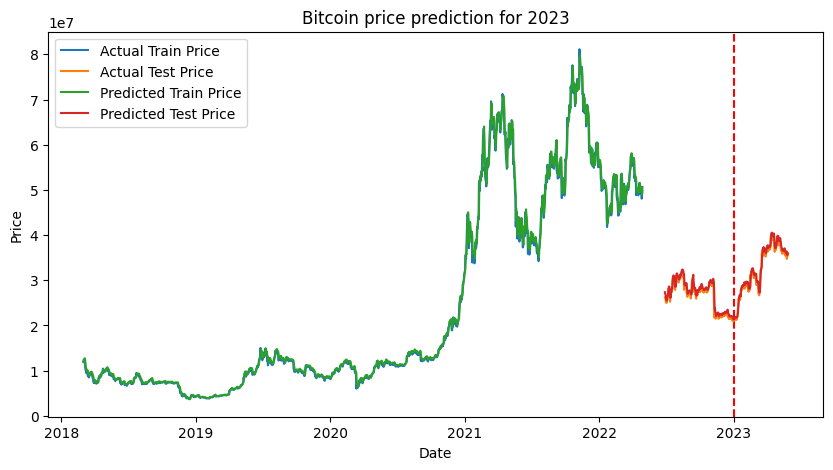

In [ ]:
import datetime
from datetime import datetime
# 예측 결과 시각화
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# train_predict와 test_predict 배열에 NaN 값이 포함되어 있는지 확인하기 위해  np.isnan() 함수를 사용
# 만약 NaN 값이 있다면, 이를 np.ma.array() 함수를 사용하여 NaN 값을 마스킹한 배열을 생성한다.
# np.ma.array()에서는 평균값을 구할수있다.(조건이 참일때 평균값을 구해서 NaN값으로 대체한다)

# train_predict와 test_predict 배열의 값을 scaler.inverse_transform() 함수를 사용하여 스케일링된 값을 원래의 값으로 복원합니다.

plt.figure(figsize=(10, 5))

# 2023년 1월 1일에 빨간색 세로축을 추가합니다.
target_date = datetime(2023, 1, 1)
plt.axvline(x=target_date, color='red', linestyle='--')

plt.plot(df[look_back:len(train_data)].index, df[look_back:len(train_data)].values, label='Actual Train Price')
plt.plot(df[len(train_data)+look_back:].index, df[len(train_data)+look_back:].values, label='Actual Test Price')
plt.plot(df[look_back:len(train_data)].index, train_predict, label='Predicted Train Price')
plt.plot(df[len(train_data)+look_back:].index, test_predict, label='Predicted Test Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin price prediction for 2023')
plt.legend()
plt.show()

In [ ]:
# train 및 test 데이터에 대한 예측값 생성
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# 스케일링 된 값을 다시 원래 값으로 변환
train_predict = scaler.inverse_transform(train_predict)  #inverse_transform() 함수를 이용해 원본값으로 복원가능하다
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])


train_r2_score = r2_score(y_train[0], train_predict[:,0])
test_r2_score = r2_score(y_test[0], test_predict[:,0])


# 결과 출력
print("Train R2 Score : ", train_r2_score)  # train 데이터의 정확도를 알려준다
print("Test R2 Score : ", test_r2_score)   # test 데이터의 정확도를 알려준다

11/11 [==============================] - 0s 10ms/step
Train R2 Score :  0.9967524212748647
Test R2 Score :  0.9648039994448304


In [ ]:
model.predict([[2023]])  # 2023년을 예측한 값이다

1/1 [==============================] - 1s 771ms/step


array([[6.5640645]], dtype=float32)

# 2. 2018년부터 2020년 데이터를 학습한후 2021년 예측하기

In [ ]:
!pip install finance-datareader # FinanceDataReader에서 데이터를 불러오기 위해 FinanceDataReader를 설치하는 과정

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install datetime

In [ ]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from sklearn.metrics import r2_score

# 데이터 불러오기
start_date_c = "2018-01-01"
end_date_c = "2021-12-31"
ticker_c = "BTC/KRW"
data_c= fdr.DataReader(ticker_c,start_date_c, end_date_c)
df_c = pd.DataFrame(fdr.DataReader(ticker_c, start_date_c, end_date_c)['Close'])

In [ ]:
df_data_c = fdr.DataReader(ticker_c, start_date_c, end_date_c)
df_data_c.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-01,15047133.0,15046287.0,14026068.0,14548333.0,14548333.0,10962700800000
2018-01-02,14514031.0,16400157.0,13990142.0,15918331.0,15918331.0,17899344238000
2018-01-03,15914188.0,16565566.0,15788165.0,16172952.0,16172952.0,17950689456200
2018-01-04,16247109.0,16707220.0,15433904.0,16552935.0,16552935.0,23115024576400
2018-01-05,16423476.0,18802922.0,16131843.0,18510128.0,18510128.0,25319034814500


In [ ]:
len(df_data_c)  # 전체 데이터의 갯수

1461

In [ ]:
# 데이터 전처리
scaler_c = MinMaxScaler()
scaled_data_c = scaler_c.fit_transform(df_c)

# minmaxScaler는 스케일을 조정하는 정규화 함수로, 모든 데이터가 0과 1사이의 값을 갖도록 해주는 함수이다
# 따라서 최댓값은 1로, 최솟값은 0으로 데이터의 범위를 조정해준다. 객체생성함

In [ ]:
scaler_c

MinMaxScaler()

In [ ]:
# train, test 데이터 생성
train_size_c = int(len(scaled_data_c) * 0.8) # 전체 데이터셋 중 80%를 학습 데이터셋으로, 20%를 테스트 데이터셋(검증용) 으로 사용하기 위해서 0.8을 곱했다
                                          # 모델 학습 시 과적합을 방지하고 일반화 성능을 높이기 위해 사용된다

train_data_c = scaled_data_c[:train_size_c]
test_data_c = scaled_data_c[train_size_c:]

def create_dataset_c(data_c, look_back_c=60):   # lock_back의 기본값은 60이다  , lock_back에다 데이터 갯수만큼 넣으면 모델학습할때 에러가 나서 기본값이 60을 집어넣었다
    x_c, y_c = [], []                  #  for문에서 얻은 모든 입력 데이터(x_c)와 출력 데이터(y_c)를 리스트에 추가한다
    for i in range(len(data_c)-look_back_c):
        x_c.append(data_c[i:(i+look_back_c), 0])   # i부터 (i+look_back)까지의 데이터를 하나의 입력 데이터 x_c 로 표현한다.
        y_c.append(data_c[i+look_back_c, 0])      # i+look_back의 데이터를 출력 데이터 y_c 로 표현한다.
    return np.array(x_c), np.array(y_c)

look_back_c = 60
x_train_c, y_train_c = create_dataset_c(train_data_c, look_back_c)
x_test_c, y_test_c = create_dataset_c(test_data_c, look_back_c)

# create_dataset()는 시계열 데이터를 RNN 모델에 입력으로 사용하기 위해 입력 데이터와 출력 데이터로 분리하는 함수이다.

In [ ]:
x_train_c

array([[0.14048103, 0.15816443, 0.16145098, ..., 0.10227909, 0.09835042,
        0.10562754],
       [0.15816443, 0.16145098, 0.16635566, ..., 0.09835042, 0.10562754,
        0.10705619],
       [0.16145098, 0.16635566, 0.19161835, ..., 0.10562754, 0.10705619,
        0.11267147],
       ...,
       [0.493835  , 0.45651485, 0.43161973, ..., 0.72179776, 0.75651919,
        0.77463487],
       [0.45651485, 0.43161973, 0.48160849, ..., 0.75651919, 0.77463487,
        0.79577821],
       [0.43161973, 0.48160849, 0.5070242 , ..., 0.77463487, 0.79577821,
        0.7937226 ]])

In [ ]:
y_train_c

array([[11958789., 12393825., 12424052., ..., 65316600., 65157344.,
        69602152.]])

In [ ]:
# 모델 생성
model_c = Sequential()   # 모델의 객체생성
model_c.add(GRU(50, input_shape=(look_back_c, 1)))  #  50=레이어의 출력 차원, input_shape=입력 데이터의 형태를 정의를 의미한다.
                                                  # lock_back=이전 데이터의 갯수만큼 비트코인 가격을 입력으로 받아들이고, 각각의 데이터가 1차원인 것을 의미합니다.

model_c.add(Dense(1))   # Dense 는 완전 연결 레이어(층)를 의미한다. 1은 출력의 차원을 의미
model_c.compile(loss='mean_squared_error', optimizer='adam')    # compile() 함수를 이용하여 모델을 컴파일합니다
                                                             # loss는 손실 함수를 의미한다.
                                                             # mean_squared_error(MSE) 는 전체 에러를 표현하기 위해서 사용하는 식이고 오차의 제곱에 대해 평균을 취한 것이다.(수치가 작을 수록 원본과의 오차가 적은 것이다)
                                                             # optimizer는  최적화 알고리즘을 정의하는 부분이다. adam(아담) 은 모멘텀+ AdaGrad(아다그라드) 을 합친 것이다

# 완전 연결 레이어 : 한 레이어의 모든 뉴런이 그 다음 레이어의 모든 뉴런과 연결된 상태이다.

# 모멘텀 : 기울기 방향으로 힘을 받아 물체가 가속된다는 물리법칙을 적용한것이다.
# AdaGrad : 학습을 진행하면서 학습률을 점차 줄여가는 방법이다.

In [ ]:
model_c

In [ ]:
# 모델 학습
model_c.fit(x_train_c, y_train_c, epochs=100, batch_size=64, verbose=2)

# x_train_c : 학습데이터의 입력값   , y_train_c : 학습데이터의 출력값이다.

# 에포크 : 훈련 데이터셋에 포함된 모든 데이터들이 한 번씩 모델을 통과한 횟수 또는 전체 학습 데이터셋에 대한 반복 횟수이다
# 에포크가 높을수록 더 많은 반복 학습을 수행하게 되므로 모델이 더 많은 학습을 하게 되어 일반적으로 더 좋은 성능을 낼 수 있습니다

# batch_size(배치크기) : 학습을 수행할 때, 몇 개의 데이터를 한 번에 처리할지를 지정한다, 일반적으로 32,64, 128 숫자를 사용한다

# verbose : 학습 과정 중 출력되는 문구를 설정합니다. 0일 경우 출력하지 않으며, 1일 경우 학습 진행 상황을 출력하고, 2일 경우 학습 결과만 출력한다

Epoch 1/100
18/18 - 3s - loss: 0.0245 - 3s/epoch - 164ms/step
Epoch 2/100
18/18 - 1s - loss: 0.0090 - 593ms/epoch - 33ms/step
Epoch 3/100
18/18 - 1s - loss: 0.0013 - 930ms/epoch - 52ms/step
Epoch 4/100
18/18 - 1s - loss: 4.1631e-04 - 997ms/epoch - 55ms/step
Epoch 5/100
18/18 - 1s - loss: 2.7425e-04 - 654ms/epoch - 36ms/step
Epoch 6/100
18/18 - 1s - loss: 2.4924e-04 - 626ms/epoch - 35ms/step
Epoch 7/100
18/18 - 1s - loss: 2.3733e-04 - 593ms/epoch - 33ms/step
Epoch 8/100
18/18 - 1s - loss: 2.3584e-04 - 589ms/epoch - 33ms/step
Epoch 9/100
18/18 - 1s - loss: 2.2441e-04 - 618ms/epoch - 34ms/step
Epoch 10/100
18/18 - 1s - loss: 2.2055e-04 - 605ms/epoch - 34ms/step
Epoch 11/100
18/18 - 1s - loss: 2.1621e-04 - 609ms/epoch - 34ms/step
Epoch 12/100
18/18 - 1s - loss: 2.1559e-04 - 612ms/epoch - 34ms/step
Epoch 13/100
18/18 - 1s - loss: 2.1003e-04 - 590ms/epoch - 33ms/step
Epoch 14/100
18/18 - 1s - loss: 2.0727e-04 - 633ms/epoch - 35ms/step
Epoch 15/100
18/18 - 1s - loss: 2.0968e-04 - 587ms/epoch 

In [ ]:
# 예측
train_predict_c = model_c.predict(x_train_c)
test_predict_c = model_c.predict(x_test_c)

# model.predict(x_train_c) 은 학습된 모델을 이용하여 train 데이터에 대한 예측값을 계산한다
# mode.predict(x_test_c) 은 학습된 모델을 이용하여 test 데이터에 대한 예측값을 계산한다.


8/8 [==============================] - 0s 8ms/step


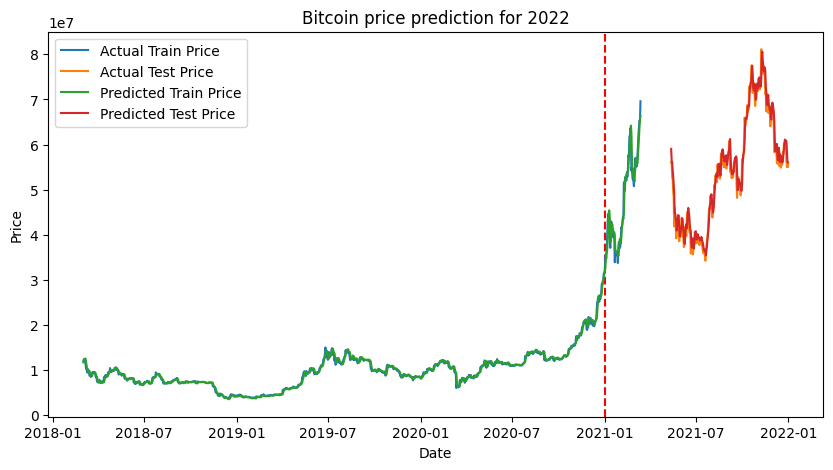

In [ ]:
import datetime
from datetime import datetime

# 예측 결과 시각화
train_predict_c = scaler_c.inverse_transform(train_predict_c)
test_predict_c = scaler_c.inverse_transform(test_predict_c)

# train_predict와 test_predict 배열에 NaN 값이 포함되어 있는지 확인하기 위해  np.isnan() 함수를 사용
# 만약 NaN 값이 있다면, 이를 np.ma.array() 함수를 사용하여 NaN 값을 마스킹한 배열을 생성한다.
# np.ma.array()에서는 평균값을 구할수있다.(조건이 참일때 평균값을 구해서 NaN값으로 대체한다)

# train_predict와 test_predict 배열의 값을 scaler.inverse_transform() 함수를 사용하여 스케일링된 값을 원래의 값으로 복원합니다.

plt.figure(figsize=(10, 5))

# 2021년 1월 1일에 빨간색 세로축을 추가합니다.
target_date = datetime(2021, 1, 1)
plt.axvline(x=target_date, color='red', linestyle='--')

plt.plot(df_c[look_back_c:len(train_data_c)].index, df_c[look_back_c:len(train_data_c)].values, label='Actual Train Price')
plt.plot(df_c[len(train_data_c)+look_back_c:].index, df_c[len(train_data_c)+look_back_c:].values, label='Actual Test Price')
plt.plot(df_c[look_back_c:len(train_data_c)].index, train_predict_c, label='Predicted Train Price')
plt.plot(df_c[len(train_data_c)+look_back_c:].index, test_predict_c, label='Predicted Test Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin price prediction for 2022')
plt.legend()
plt.show()

In [ ]:
# train 및 test 데이터에 대한 예측값 생성
train_predict_c = model_c.predict(x_train_c)
test_predict_c = model_c.predict(x_test_c)

# 스케일링 된 값을 다시 원래 값으로 변환
train_predict_c = scaler_c.inverse_transform(train_predict_c)  #inverse_transform() 함수를 이용해 원본값으로 복원가능하다
y_train_c = scaler_c.inverse_transform([y_train_c])
test_predict_c = scaler_c.inverse_transform(test_predict_c)
y_test_c = scaler_c.inverse_transform([y_test_c])


train_r2_score_c = r2_score(y_train_c[0], train_predict_c[:,0])
test_r2_score_c = r2_score(y_test_c[0], test_predict_c[:,0])


# 결과 출력
print("Train R2 Score_c : ", train_r2_score_c) # train 데이터의 정확도를 알려준다
print("Test R2 Score_c : ", test_r2_score_c)   # test 데이터의 정확도를 알려준다

8/8 [==============================] - 0s 9ms/step
Train R2 Score_c :  0.9946859835187558
Test R2 Score_c :  0.9654137780595117


In [ ]:
model_c.predict([[2021]])  # 2024년 예측값이다.

1/1 [==============================] - 0s 409ms/step


array([[5.115591]], dtype=float32)

# 3. 2019년부터 2021년데이터를 학습한후 2022년 예측하기

In [ ]:
!pip install finance-datareader # FinanceDataReader에서 데이터를 불러오기 위해 FinanceDataReader를 설치하는 과정

In [ ]:
pip install datetime

In [ ]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from sklearn.metrics import r2_score

# 데이터 불러오기
start_date_d = "2019-01-01"
end_date_d = "2022-12-31"
ticker_d = "BTC/KRW"
data_d= fdr.DataReader(ticker_d,start_date_d, end_date_d)
df_d = pd.DataFrame(fdr.DataReader(ticker_d, start_date_d, end_date_d)['Close'])

In [ ]:
df_data_d = fdr.DataReader(ticker_d, start_date_d, end_date_d)
df_data_d.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-01,4171964.75,4290765.0,4133847.0,4284795.0,4284795.0,4820662946950
2019-01-02,4291491.50,4432793.5,4271306.5,4428835.0,4428835.0,5890487949740
2019-01-03,4415052.00,4431168.0,4308021.0,4316672.0,4316672.0,5096891156140
2019-01-04,4311528.00,4318403.5,4249898.5,4308451.5,4308451.5,5414399614310
2019-01-05,4302037.00,4361150.5,4285202.0,4294465.5,4294465.5,5737885889880


In [ ]:
len(df_data_d)

1461

In [ ]:
# 데이터 전처리
scaler_d = MinMaxScaler()
scaled_data_d = scaler_d.fit_transform(df_d)

# minmaxScaler는 스케일을 조정하는 정규화 함수로, 모든 데이터가 0과 1사이의 값을 갖도록 해주는 함수이다
# 따라서 최댓값은 1로, 최솟값은 0으로 데이터의 범위를 조정해준다. 객체생성함

In [ ]:
scaler_d

MinMaxScaler()

In [ ]:
# train, test 데이터 생성
train_size_d = int(len(scaled_data_d) * 0.8)
train_data_d = scaled_data_d[:train_size_d]
test_data_d = scaled_data_d[train_size_d:]

def create_dataset_d(data_d, look_back=60):   # lock_back의 기본값은 60이다  , lock_back에다 데이터 갯수마큼 넣으면 모델학습할때 에러가 나서 기본값이 60을 집어넣었다
                                             #look_back은 몇 개의 과거 데이터를 사용할 것인지를 표현하는 것이다
    x_d, y_d = [], []    #  for문에서 얻은 모든 입력 데이터(x_d)와 출력 데이터(y_d)를 리스트에 추가한다
    for i in range(len(data_d)-look_back):
        x_d.append(data_d[i:(i+look_back), 0])   # i부터 (i+look_back)까지의 데이터를 하나의 입력 데이터 x_d 로 표현한다.
        y_d.append(data_d[i+look_back, 0])      # i+look_back의 데이터를 출력 데이터 y_d 로 표현한다.
    return np.array(x_d), np.array(y_d)       # 리스트를 numpy 배열로 변환하여 반환


look_back = 60
x_train_d, y_train_d = create_dataset_d(train_data_d, look_back)
x_test_d, y_test_d = create_dataset_d(test_data_d, look_back)

In [ ]:
x_train_d

array([[0.00596423, 0.00782726, 0.00637653, ..., 0.00618687, 0.00664541,
        0.00683718],
       [0.00782726, 0.00637653, 0.0062702 , ..., 0.00664541, 0.00683718,
        0.00690765],
       [0.00637653, 0.0062702 , 0.0060893 , ..., 0.00683718, 0.00690765,
        0.00666332],
       ...,
       [0.59865281, 0.60804501, 0.62469167, ..., 0.56887489, 0.61480135,
        0.57731183],
       [0.60804501, 0.62469167, 0.60434885, ..., 0.61480135, 0.57731183,
        0.57129838],
       [0.62469167, 0.60434885, 0.61406374, ..., 0.57731183, 0.57129838,
        0.5730431 ]])

In [ ]:
y_train_d

array([[ 4357735.5,  4338845. ,  4247287. , ..., 47993456. , 48128348. ,
        46814516. ]])

In [ ]:
# 모델 생성
model_d = Sequential()   # 모델의 객체생성
model_d.add(GRU(50, input_shape=(look_back, 1))) #  50=레이어의 출력 차원, input_shape=입력 데이터의 형태를 정의를 의미한다.
                                                  # lock_back=이전 데이터의 갯수만큼 비트코인 가격을 입력으로 받아들이고, 각각의 데이터가 1차원인 것을 의미합니다.

model_d.add(Dense(1))   # Dense 는 완전 연결 레이어(층)를 의미한다. 1은 출력의 차원을 의미
model_d.compile(loss='mean_squared_error', optimizer='adam') # compile() 함수를 이용하여 모델을 컴파일합니다
                                                             # loss는 손실 함수를 의미한다.
                                                             # mean_squared_error(MSE) 는 전체 에러를 표현하기 위해서 사용하는 식이고 오차의 제곱에 대해 평균을 취한 것이다.(수치가 작을 수록 원본과의 오차가 적은 것이다)
                                                             # optimizer는  최적화 알고리즘을 정의하는 부분이다. adam(아담) 은 모멘텀+ AdaGrad(아다그라드) 을 합친 것이다

# 완전 연결 레이어 : 한 레이어의 모든 뉴런이 그 다음 레이어의 모든 뉴런과 연결된 상태이다.
# 모멘텀 : 기울기 방향으로 힘을 받아 물체가 가속된다는 물리법칙을 적용한것이다.
# AdaGrad : 학습을 진행하면서 학습률을 점차 줄여가는 방법이다.

In [ ]:
model_d

In [ ]:
# 모델 학습
model_d.fit(x_train_d, y_train_d, epochs=100, batch_size=64, verbose=2)

# x_train_d : 학습데이터의 입력값   , y_train_d: 학습데이터의 출력값이다.

# 에포크 : 훈련 데이터셋에 포함된 모든 데이터들이 한 번씩 모델을 통과한 횟수 또는 전체 학습 데이터셋에 대한 반복 횟수이다
# 에포크가 높을수록 더 많은 반복 학습을 수행하게 되므로 모델이 더 많은 학습을 하게 되어 일반적으로 더 좋은 성능을 낼 수 있습니다

# batch_size(배치크기) : 학습을 수행할 때, 몇 개의 데이터를 한 번에 처리할지를 지정한다, 일반적으로 32,64, 128 숫자를 사용한다

# verbose : 학습 과정 중 출력되는 문구를 설정합니다. 0일 경우 출력하지 않으며, 1일 경우 학습 진행 상황을 출력하고, 2일 경우 학습 결과만 출력한다

Epoch 1/100
18/18 - 1s - loss: 3.2982e-04 - 658ms/epoch - 37ms/step
Epoch 2/100
18/18 - 1s - loss: 3.4459e-04 - 646ms/epoch - 36ms/step
Epoch 3/100
18/18 - 1s - loss: 3.3469e-04 - 595ms/epoch - 33ms/step
Epoch 4/100
18/18 - 1s - loss: 3.3424e-04 - 605ms/epoch - 34ms/step
Epoch 5/100
18/18 - 1s - loss: 3.3674e-04 - 616ms/epoch - 34ms/step
Epoch 6/100
18/18 - 1s - loss: 3.3015e-04 - 654ms/epoch - 36ms/step
Epoch 7/100
18/18 - 1s - loss: 3.3063e-04 - 625ms/epoch - 35ms/step
Epoch 8/100
18/18 - 1s - loss: 3.3127e-04 - 604ms/epoch - 34ms/step
Epoch 9/100
18/18 - 1s - loss: 3.4544e-04 - 583ms/epoch - 32ms/step
Epoch 10/100
18/18 - 1s - loss: 3.6096e-04 - 596ms/epoch - 33ms/step
Epoch 11/100
18/18 - 1s - loss: 3.2939e-04 - 580ms/epoch - 32ms/step
Epoch 12/100
18/18 - 1s - loss: 3.5512e-04 - 920ms/epoch - 51ms/step
Epoch 13/100
18/18 - 1s - loss: 3.3370e-04 - 1s/epoch - 57ms/step
Epoch 14/100
18/18 - 1s - loss: 3.3033e-04 - 641ms/epoch - 36ms/step
Epoch 15/100
18/18 - 1s - loss: 3.4137e-04 - 6

In [ ]:
# 예측
train_predict_d = model_d.predict(x_train_d)
test_predict_d = model_d.predict(x_test_d)

# model.predict(x_train_d) 은 학습된 모델을 이용하여 train 데이터에 대한 예측값을 계산한다
# mode.predict(x_test_d) 은 학습된 모델을 이용하여 test 데이터에 대한 예측값을 계산한다.

8/8 [==============================] - 0s 9ms/step


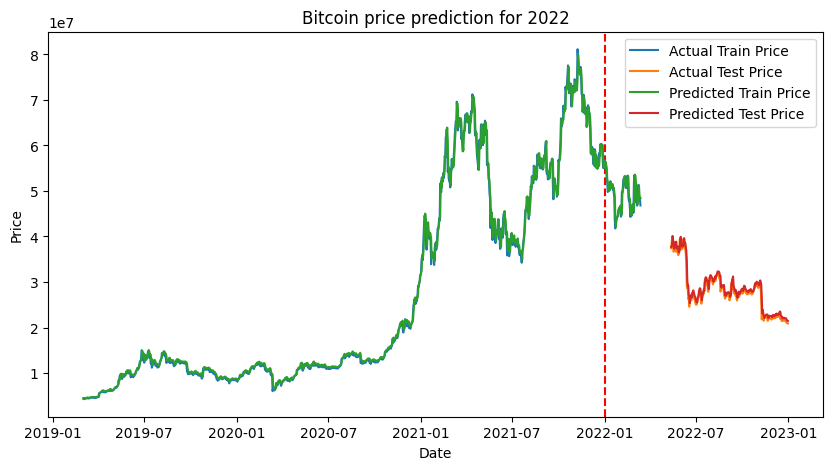

In [ ]:
import datetime
from datetime import datetime

# 예측 결과 시각화
train_predict_d = scaler_d.inverse_transform(train_predict_d)
test_predict_d = scaler_d.inverse_transform(test_predict_d)

# train_predict와 test_predict 배열에 NaN 값이 포함되어 있는지 확인하기 위해  np.isnan() 함수를 사용
# 만약 NaN 값이 있다면, 이를 np.ma.array() 함수를 사용하여 NaN 값을 마스킹한 배열을 생성한다.
# np.ma.array()에서는 평균값을 구할수있다.(조건이 참일때 평균값을 구해서 NaN값으로 대체한다)

# train_predict와 test_predict 배열의 값을 scaler.inverse_transform() 함수를 사용하여 스케일링된 값을 원래의 값으로 복원합니다.

plt.figure(figsize=(10, 5))

# 2022년 1월 1일에 빨간색 세로축을 추가합니다.
target_date = datetime(2022, 1, 1)
plt.axvline(x=target_date, color='red', linestyle='--')

plt.plot(df_d[look_back:len(train_data_d)].index, df_d[look_back:len(train_data_d)].values, label='Actual Train Price')
plt.plot(df_d[len(train_data_d)+look_back:].index, df_d[len(train_data_d)+look_back:].values, label='Actual Test Price')
plt.plot(df_d[look_back:len(train_data_d)].index, train_predict_d, label='Predicted Train Price')
plt.plot(df_d[len(train_data_d)+look_back:].index, test_predict_d, label='Predicted Test Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin price prediction for 2022')
plt.legend()
plt.show()

In [ ]:
# train 및 test 데이터에 대한 예측값 생성
train_predict_d = model_d.predict(x_train_d)
test_predict_d = model_d.predict(x_test_d)

# 스케일링 된 값을 다시 원래 값으로 변환
train_predict_d = scaler_d.inverse_transform(train_predict_d)  #inverse_transform() 함수를 이용해 원본값으로 복원가능하다
y_train_d = scaler_d.inverse_transform([y_train_d])
test_predict_d = scaler_d.inverse_transform(test_predict_d)
y_test_d = scaler_d.inverse_transform([y_test_d])


train_r2_score_d = r2_score(y_train_d[0], train_predict_d[:,0])
test_r2_score_d = r2_score(y_test_d[0], test_predict_d[:,0])


# 결과 출력
print("Train R2 Score_d : ", train_r2_score_d) # train 데이터의 정확도를 알려준다
print("Test R2 Score_d : ", test_r2_score_d)   # test 데이터의 정확도를 알려준다

8/8 [==============================] - 0s 9ms/step
Train R2 Score_d :  0.9961280124544134
Test R2 Score_d :  0.9465117906664735


In [ ]:
print(model_d.predict([[2022]]))  # 2022년에 예측값이다.

1/1 [==============================] - 0s 411ms/step
[[6.2447257]]


## 4. 2020년 부터 2022년 데이터를 학습한 후 2023년 예측해보는 프로그램

In [ ]:
!pip install finance-datareader # FinanceDataReader에서 데이터를 불러오기 위해 FinanceDataReader를 설치하는 과정

In [ ]:
pip install datetime

In [ ]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from sklearn.metrics import r2_score

# 데이터 불러오기
start_date_e = "2020-01-01"
end_date_e = "2023-12-31"
ticker_e = "BTC/KRW"
data_e= fdr.DataReader(ticker_e,start_date_e, end_date_e)
df_e = pd.DataFrame(fdr.DataReader(ticker_e, start_date_e, end_date_e)['Close'])

In [ ]:
df_data_e = fdr.DataReader(ticker_e, start_date_e, end_date_e)
df_data_e.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,8308229.5,8376938.5,8287634.5,8315985.5,8315985.5,21442786101341
2020-01-02,8318730.5,8335989.5,8026049.5,8084144.5,8084144.5,24073835152756
2020-01-03,8082939.5,8638980.0,8022294.0,8563107.0,8563107.0,32774051275895
2020-01-04,8563679.0,8659292.0,8521870.0,8639788.0,8639788.0,21503438108393
2020-01-05,8639549.0,8795827.0,8628617.0,8641188.0,8641188.0,22998351377088


In [ ]:
len(df_data_e)

1248

In [ ]:
# 데이터 전처리
scaler_e = MinMaxScaler()
scaled_data_e = scaler_e.fit_transform(df_e)

# minmaxScaler는 스케일을 조정하는 정규화 함수로, 모든 데이터가 0과 1사이의 값을 갖도록 해주는 함수이다
# 따라서 최댓값은 1로, 최솟값은 0으로 데이터의 범위를 조정해준다. 객체생성함

In [ ]:
scaler_e

MinMaxScaler()

In [ ]:
# train, test 데이터 생성
train_size_e = int(len(scaled_data_e) * 0.8)
train_data_e = scaled_data_e[:train_size_e]
test_data_e = scaled_data_e[train_size_e:]

def create_dataset_e(data_e, look_back=60):   # lock_back의 기본값은 60이다  , lock_back에다 데이터 갯수만큼 넣으면 모델학습할때 에러가 나서 기본값이 60을 집어넣었다
                                               # 모델 학습 시 과적합을 방지하고 일반화 성능을 높이기 위해 사용된다

    x_e, y_e = [], []  #  for문에서 얻은 모든 입력 데이터(x_e)와 출력 데이터(y_e)를 리스트에 추가한다

    for i in range(len(data_e)-look_back):
        x_e.append(data_e[i:(i+look_back), 0])     # i부터 (i+look_back)까지의 데이터를 하나의 입력 데이터 x_e 로 표현한다.
        y_e.append(data_e[i+look_back, 0])   # i+look_back의 데이터를 출력 데이터 y_e 로 표현한다.
    return np.array(x_e), np.array(y_e)      # 리스트를 numpy 배열로 변환하여 반환

look_back = 60
x_train_e, y_train_e = create_dataset_e(train_data_e, look_back)
x_test_e, y_test_e = create_dataset_e(test_data_e, look_back)

# create_dataset()는 시계열 데이터를 RNN 모델에 입력으로 사용하기 위해 입력 데이터와 출력 데이터로 분리하는 함수이다.

In [ ]:
x_train_e

array([[0.03057166, 0.02748534, 0.0338614 , ..., 0.06163633, 0.05844336,
        0.05727776],
       [0.02748534, 0.0338614 , 0.03488219, ..., 0.05844336, 0.05727776,
        0.05668567],
       [0.0338614 , 0.03488219, 0.03490083, ..., 0.05727776, 0.05668567,
        0.06026688],
       ...,
       [0.31424465, 0.29263324, 0.29062118, ..., 0.28162885, 0.2701391 ,
        0.26498431],
       [0.29263324, 0.29062118, 0.3186088 , ..., 0.2701391 , 0.26498431,
        0.28288207],
       [0.29062118, 0.3186088 , 0.33125328, ..., 0.26498431, 0.28288207,
        0.28542566]])

In [ ]:
 y_train_e

array([[10277642.        , 10546659.        , 10428598.        ,
        10371464.        , 10789837.        , 10844882.        ,
        10592153.        ,  9638118.        ,  9516733.        ,
         9373029.        ,  9425678.        ,  6019475.        ,
         6742100.        ,  6301804.        ,  6534461.        ,
         6183004.5       ,  6474502.5       ,  6581260.        ,
         7787777.5       ,  7779156.5       ,  7761949.        ,
         7315012.5       ,  8112756.5       ,  8309872.5       ,
         8224956.5       ,  8148318.5       ,  7846183.        ,
         7570158.        ,  7181247.        ,  7871669.5       ,
         7840080.5       ,  8164720.5       ,  8341552.        ,
         8327887.        ,  8493792.        ,  8399269.        ,
         8901460.        ,  8721497.        ,  8916430.        ,
         8839325.        ,  8321939.        ,  8314169.        ,
         8449242.        ,  8315968.        ,  8296170.        ,
         8126488.5       

In [ ]:
# 모델 생성
model_e = Sequential()   # 모델의 객체생성
model_e.add(GRU(50, input_shape=(look_back, 1))) #  50=레이어의 출력 차원, input_shape=입력 데이터의 형태를 정의를 의미한다.
                                                  # lock_back=이전 데이터의 갯수만큼 비트코인 가격을 입력으로 받아들이고, 각각의 데이터가 1차원인 것을 의미합니다.

model_e.add(Dense(1))   # Dense 는 완전 연결 레이어(층)를 의미한다. 1은 출력의 차원을 의미
model_e.compile(loss='mean_squared_error', optimizer='adam')  # compile() 함수를 이용하여 모델을 컴파일합니다
                                                             # loss는 손실 함수를 의미한다.
                                                             # mean_squared_error(MSE) 는 전체 에러를 표현하기 위해서 사용하는 식이고 오차의 제곱에 대해 평균을 취한 것이다.(수치가 작을 수록 원본과의 오차가 적은 것이다)
                                                             # optimizer는  최적화 알고리즘을 정의하는 부분이다. adam(아담) 은 모멘텀+ AdaGrad(아다그라드) 을 합친 것이다

# 완전 연결 레이어 : 한 레이어의 모든 뉴런이 그 다음 레이어의 모든 뉴런과 연결된 상태이다.
# 모멘텀 : 기울기 방향으로 힘을 받아 물체가 가속된다는 물리법칙을 적용한것이다.
# AdaGrad : 학습을 진행하면서 학습률을 점차 줄여가는 방법이다.

In [ ]:
model_e

In [ ]:
# 모델 학습
model_e.fit(x_train_e, y_train_e, epochs=100, batch_size=64, verbose=2)   # 데이터 갯수가 많으면 에포크는 50~100 사이, 배치사이즈는 32~64 사이로 지정

# 배치사이즈 = 64 는 1096개의 데이터를 64개씩 묶어서 17번의 배치로 학습을 진행하게 됩니다.

# x_train_e : 학습데이터의 입력값   , y_train_e : 학습데이터의 출력값이다.

# 에포크 : 훈련 데이터셋에 포함된 모든 데이터들이 한 번씩 모델을 통과한 횟수 또는 전체 학습 데이터셋에 대한 반복 횟수이다
# 에포크가 높을수록 더 많은 반복 학습을 수행하게 되므로 모델이 더 많은 학습을 하게 되어 일반적으로 더 좋은 성능을 낼 수 있습니다

# batch_size(배치크기) : 학습을 수행할 때, 몇 개의 데이터를 한 번에 처리할지를 지정한다, 일반적으로 32,64, 128 숫자를 사용한다

# verbose : 학습 과정 중 출력되는 문구를 설정합니다. 0일 경우 출력하지 않으며, 1일 경우 학습 진행 상황을 출력하고, 2일 경우 학습 결과만 출력한다

Epoch 1/100
15/15 - 3s - loss: 0.1866 - 3s/epoch - 213ms/step
Epoch 2/100
15/15 - 1s - loss: 0.0303 - 542ms/epoch - 36ms/step
Epoch 3/100
15/15 - 1s - loss: 0.0177 - 530ms/epoch - 35ms/step
Epoch 4/100
15/15 - 1s - loss: 0.0098 - 534ms/epoch - 36ms/step
Epoch 5/100
15/15 - 1s - loss: 0.0045 - 519ms/epoch - 35ms/step
Epoch 6/100
15/15 - 1s - loss: 0.0018 - 734ms/epoch - 49ms/step
Epoch 7/100
15/15 - 1s - loss: 0.0012 - 881ms/epoch - 59ms/step
Epoch 8/100
15/15 - 1s - loss: 0.0011 - 713ms/epoch - 48ms/step
Epoch 9/100
15/15 - 0s - loss: 0.0011 - 486ms/epoch - 32ms/step
Epoch 10/100
15/15 - 1s - loss: 0.0011 - 511ms/epoch - 34ms/step
Epoch 11/100
15/15 - 0s - loss: 0.0010 - 495ms/epoch - 33ms/step
Epoch 12/100
15/15 - 1s - loss: 9.6841e-04 - 510ms/epoch - 34ms/step
Epoch 13/100
15/15 - 1s - loss: 9.4463e-04 - 523ms/epoch - 35ms/step
Epoch 14/100
15/15 - 1s - loss: 9.4867e-04 - 547ms/epoch - 36ms/step
Epoch 15/100
15/15 - 1s - loss: 9.3276e-04 - 519ms/epoch - 35ms/step
Epoch 16/100
15/15 -

In [ ]:
# 예측
train_predict_e = model_e.predict(x_train_e)
test_predict_e = model_e.predict(x_test_e)

# model.predict(x_train_d) 은 학습된 모델을 이용하여 train 데이터에 대한 예측값을 계산한다
# mode.predict(x_test_d) 은 학습된 모델을 이용하여 test 데이터에 대한 예측값을 계산한다.

6/6 [==============================] - 0s 9ms/step


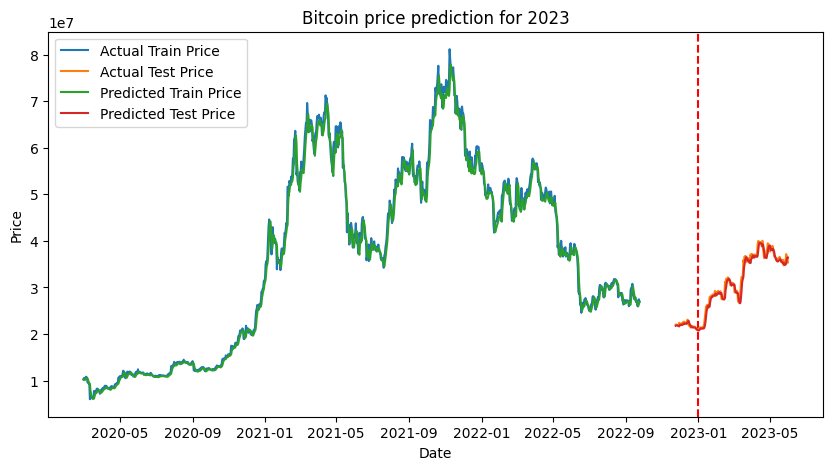

In [ ]:
import datetime
from datetime import datetime

# 예측 결과 시각화
train_predict_e = scaler_e.inverse_transform(train_predict_e)
test_predict_e = scaler_e.inverse_transform(test_predict_e)

# train_predict와 test_predict 배열에 NaN 값이 포함되어 있는지 확인하기 위해  np.isnan() 함수를 사용
# 만약 NaN 값이 있다면, 이를 np.ma.array() 함수를 사용하여 NaN 값을 마스킹한 배열을 생성한다.
# np.ma.array()에서는 평균값을 구할수있다.(조건이 참일때 평균값을 구해서 NaN값으로 대체한다)

# train_predict와 test_predict 배열의 값을 scaler.inverse_transform() 함수를 사용하여 스케일링된 값을 원래의 값으로 복원합니다.

plt.figure(figsize=(10, 5))

# 2023년 1월 1일에 빨간색 세로축을 추가합니다.
target_date = datetime(2023, 1, 1)
plt.axvline(x=target_date, color='red', linestyle='--')

plt.plot(df_e[look_back:len(train_data_e)].index, df_e[look_back:len(train_data_e)].values, label='Actual Train Price')
plt.plot(df_e[len(train_data_e)+look_back:].index, df_e[len(train_data_e)+look_back:].values, label='Actual Test Price')
plt.plot(df_e[look_back:len(train_data_e)].index, train_predict_e, label='Predicted Train Price')
plt.plot(df_e[len(train_data_e)+look_back:].index, test_predict_e, label='Predicted Test Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin price prediction for 2023')
plt.legend()
plt.show()

In [ ]:
# train 및 test 데이터에 대한 예측값 생성
train_predict_e = model_e.predict(x_train_e)
test_predict_e = model_e.predict(x_test_e)

# 스케일링 된 값을 다시 원래 값으로 변환
train_predict_e = scaler_e.inverse_transform(train_predict_e)  #inverse_transform() 함수를 이용해 원본값으로 복원가능하다
y_train_e = scaler_e.inverse_transform([y_train_e])
test_predict_e = scaler_e.inverse_transform(test_predict_e)
y_test_e = scaler_e.inverse_transform([y_test_e])


train_r2_score_e = r2_score(y_train_e[0], train_predict_e[:,0])
test_r2_score_e = r2_score(y_test_e[0], test_predict_e[:,0])


# 결과 출력
print("Train R2 Score_e : ", train_r2_score_e) # train 데이터의 정확도를 알려준다
print("Test R2 Score_e : ", test_r2_score_e)   # test 데이터의 정확도를 알려준다

6/6 [==============================] - 0s 12ms/step
Train R2 Score_e :  0.9920918238838435
Test R2 Score_e :  0.9801638396056107


In [ ]:
print(model_e.predict([[2023]]))  # 2023년에 예측값이다.

1/1 [==============================] - 0s 396ms/step
[[5.3140836]]


## 5. 일론머스크 (2021년 5월 13일)

In [ ]:
!pip install finance-datareader # FinanceDataReader에서 데이터를 불러오기 위해 FinanceDataReader를 설치하는 과정

In [ ]:
pip install datetime

In [ ]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from sklearn.metrics import r2_score

# 데이터 불러오기
start_date_q = "2018-01-01"
end_date_q = "2021-12-31"
ticker_q = "BTC/KRW"  # 한국거래소에서 비트코인을 가격 데이터 가져오기
df_data_q = fdr.DataReader(ticker_q, start_date_q, end_date_q)
df_q = pd.DataFrame(fdr.DataReader(ticker_q, start_date_q, end_date_q)['Close'])

In [ ]:
df_data_q = fdr.DataReader(ticker_q, start_date_q, end_date_q)
df_data_q.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-01,15047133.0,15046287.0,14026068.0,14548333.0,14548333.0,10962700800000
2018-01-02,14514031.0,16400157.0,13990142.0,15918331.0,15918331.0,17899344238000
2018-01-03,15914188.0,16565566.0,15788165.0,16172952.0,16172952.0,17950689456200
2018-01-04,16247109.0,16707220.0,15433904.0,16552935.0,16552935.0,23115024576400
2018-01-05,16423476.0,18802922.0,16131843.0,18510128.0,18510128.0,25319034814500


In [ ]:
len(df_data_q)

1461

In [ ]:
# 데이터 전처리
scaler_q = MinMaxScaler()
scaled_data_q = scaler_q.fit_transform(df_q) # minmaxScaler는 스케일을 조정하는 정규화 함수로, 모든 데이터가 0과 1사이의 값을 갖도록 해주는 함수이다
                          # 따라서 최댓값은 1로, 최솟값은 0으로 데이터의 범위를 조정해준다. 객체생성함

In [ ]:
scaler_q

MinMaxScaler()

In [ ]:
# train, test 데이터 생성

train_size_q = int(len(scaled_data_q) * 0.8)   ## 전체 데이터셋 중 80%를 학습 데이터셋으로, 20%를 테스트 데이터셋(검증용) 으로 사용하기 위해서 0.8을 곱했다
                                          # 모델 학습 시 과적합을 방지하고 일반화 성능을 높이기 위해 사용된다
train_data_q = scaled_data_q[:train_size_q]
test_data_q = scaled_data_q[train_size_q:]

def create_dataset_q(data, look_back=60): #look_back은 몇 개의 과거 데이터를 사용할 것인지를 표현하는 것이다(기본값이 60이다)
    x_q, y_q = [], []        #  for문에서 얻은 모든 입력 데이터(x)와 출력 데이터(y)를 리스트에 추가한다
    for i in range(len(data)-look_back):
        x_q.append(data[i:(i+look_back), 0])   # i부터 (i+look_back)까지의 데이터를 하나의 입력 데이터 x 로 표현한다.
        y_q.append(data[i+look_back, 0])       # i+look_back의 데이터를 출력 데이터 y 로 표현한다.
    return np.array(x_q), np.array(y_q)         # 리스트를 numpy 배열로 변환하여 반환

# create_dataset()는 시계열 데이터를 RNN 모델에 입력으로 사용하기 위해 입력 데이터와 출력 데이터로 분리하는 함수이다.

look_back = 60
x_train_q, y_train_q = create_dataset_q(train_data_q, look_back)
x_test_q, y_test_q = create_dataset_q(test_data_q, look_back)

In [ ]:
x_train_q

array([[0.14048103, 0.15816443, 0.16145098, ..., 0.10227909, 0.09835042,
        0.10562754],
       [0.15816443, 0.16145098, 0.16635566, ..., 0.09835042, 0.10562754,
        0.10705619],
       [0.16145098, 0.16635566, 0.19161835, ..., 0.10562754, 0.10705619,
        0.11267147],
       ...,
       [0.493835  , 0.45651485, 0.43161973, ..., 0.72179776, 0.75651919,
        0.77463487],
       [0.45651485, 0.43161973, 0.48160849, ..., 0.75651919, 0.77463487,
        0.79577821],
       [0.43161973, 0.48160849, 0.5070242 , ..., 0.77463487, 0.79577821,
        0.7937226 ]])

In [ ]:
y_train_q

array([[11958789., 12393825., 12424052., ..., 65316600., 65157344.,
        69602152.]])

In [ ]:
# 모델 생성
model_q = Sequential()   # 모델의 객체생성
model_q.add(GRU(50, input_shape=(look_back, 1)))   #  50=레이어의 출력 차원, input_shape=입력 데이터의 형태를 정의를 의미한다.
                                                  # lock_back=이전 데이터의 갯수만큼 비트코인 가격을 입력으로 받아들이고, 각각의 데이터가 1차원인 것을 의미합니다.

model_q.add(Dense(1))   # Dense 는 완전 연결 레이어(층)를 의미한다. 1은 출력의 차원을 의미

model_q.compile(loss='mean_squared_error', optimizer='adam')  # compile() 함수를 이용하여 모델을 컴파일합니다
                                                             # loss는 손실 함수를 의미한다.
                                                             # mean_squared_error(MSE) 는 전체 에러를 표현하기 위해서 사용하는 식이고 오차의 제곱에 대해 평균을 취한 것이다.(수치가 작을 수록 원본과의 오차가 적은 것이다)
                                                             # optimizer는  최적화 알고리즘을 정의하는 부분이다. adam(아담) 은 모멘텀+ AdaGrad(아다그라드) 을 합친 것이다

# 완전 연결 레이어 : 한 레이어의 모든 뉴런이 그 다음 레이어의 모든 뉴런과 연결된 상태이다.

# 모멘텀 : 기울기 방향으로 힘을 받아 물체가 가속된다는 물리법칙을 적용한것이다.
# AdaGrad : 학습을 진행하면서 학습률을 점차 줄여가는 방법이다.

In [ ]:
model_q

In [ ]:
# 모델 학습
model_q.fit(x_train_q, y_train_q, epochs=100, batch_size=64, verbose=2)

# x_train : 학습데이터의 입력값   , y_train : 학습데이터의 출력값이다.

# 에포크 : 훈련 데이터셋에 포함된 모든 데이터들이 한 번씩 모델을 통과한 횟수 또는 전체 학습 데이터셋에 대한 반복 횟수이다
# 에포크가 높을수록 더 많은 반복 학습을 수행하게 되므로 모델이 더 많은 학습을 하게 되어 일반적으로 더 좋은 성능을 낼 수 있습니다

# batch_size(배치크기) : 학습을 수행할 때, 몇 개의 데이터를 한 번에 처리할지를 지정한다, 일반적으로 32,64, 128 숫자를 사용한다

# verbose : 학습 과정 중 출력되는 문구를 설정합니다. 0일 경우 출력하지 않으며, 1일 경우 학습 진행 상황을 출력하고, 2일 경우 학습 결과만 출력한다

Epoch 1/100
18/18 - 3s - loss: 0.0178 - 3s/epoch - 156ms/step
Epoch 2/100
18/18 - 1s - loss: 0.0046 - 585ms/epoch - 33ms/step
Epoch 3/100
18/18 - 1s - loss: 5.6446e-04 - 610ms/epoch - 34ms/step
Epoch 4/100
18/18 - 1s - loss: 3.2847e-04 - 586ms/epoch - 33ms/step
Epoch 5/100
18/18 - 1s - loss: 2.3281e-04 - 589ms/epoch - 33ms/step
Epoch 6/100
18/18 - 1s - loss: 2.2198e-04 - 605ms/epoch - 34ms/step
Epoch 7/100
18/18 - 1s - loss: 2.1538e-04 - 593ms/epoch - 33ms/step
Epoch 8/100
18/18 - 1s - loss: 2.1254e-04 - 586ms/epoch - 33ms/step
Epoch 9/100
18/18 - 1s - loss: 2.1197e-04 - 595ms/epoch - 33ms/step
Epoch 10/100
18/18 - 1s - loss: 2.0542e-04 - 596ms/epoch - 33ms/step
Epoch 11/100
18/18 - 1s - loss: 2.0823e-04 - 570ms/epoch - 32ms/step
Epoch 12/100
18/18 - 1s - loss: 1.9891e-04 - 956ms/epoch - 53ms/step
Epoch 13/100
18/18 - 1s - loss: 2.0022e-04 - 969ms/epoch - 54ms/step
Epoch 14/100
18/18 - 1s - loss: 1.9084e-04 - 622ms/epoch - 35ms/step
Epoch 15/100
18/18 - 1s - loss: 1.9989e-04 - 567ms/ep

In [ ]:
# 예측
train_predict_q = model_q.predict(x_train_q)
test_predict_q = model_q.predict(x_test_q)

# model.predict(x_train) 은 학습된 모델을 이용하여 train 데이터에 대한 예측값을 계산한다
# mode.predict(x_test) 은 학습된 모델을 이용하여 test 데이터에 대한 예측값을 계산한다.

8/8 [==============================] - 0s 8ms/step


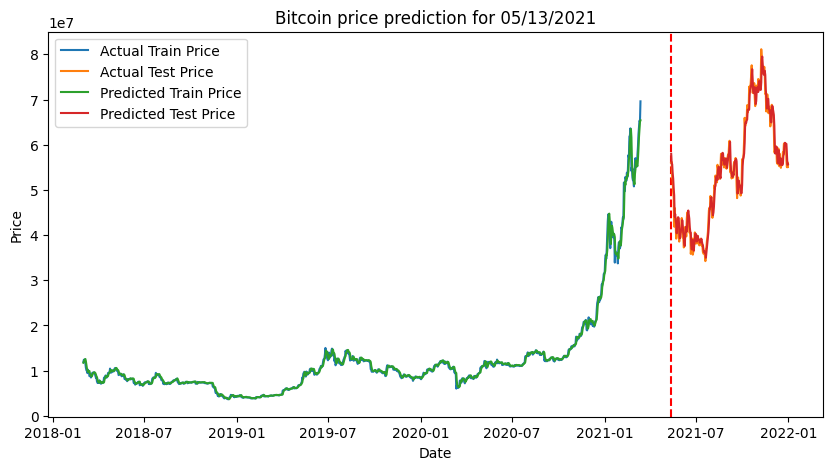

In [ ]:
import datetime
from datetime import datetime

# 예측 결과 시각화
train_predict_q = scaler_q.inverse_transform(train_predict_q)
test_predict_q = scaler_q.inverse_transform(test_predict_q)

# train_predict와 test_predict 배열에 NaN 값이 포함되어 있는지 확인하기 위해  np.isnan() 함수를 사용
# 만약 NaN 값이 있다면, 이를 np.ma.array() 함수를 사용하여 NaN 값을 마스킹한 배열을 생성한다.
# np.ma.array()에서는 평균값을 구할수있다.(조건이 참일때 평균값을 구해서 NaN값으로 대체한다)

# train_predict와 test_predict 배열의 값을 scaler.inverse_transform() 함수를 사용하여 스케일링된 값을 원래의 값으로 복원합니다.

plt.figure(figsize=(10, 5))

# 2021년 5월 13일에 빨간색 세로축을 추가합니다.
target_date = datetime(2021, 5, 13)
plt.axvline(x=target_date, color='red', linestyle='--')

plt.plot(df_q[look_back:len(train_data_q)].index, df_q[look_back:len(train_data_q)].values, label='Actual Train Price')
plt.plot(df_q[len(train_data_q)+look_back:].index, df_q[len(train_data_q)+look_back:].values, label='Actual Test Price')
plt.plot(df_q[look_back:len(train_data_q)].index, train_predict_q, label='Predicted Train Price')
plt.plot(df_q[len(train_data_q)+look_back:].index, test_predict_q, label='Predicted Test Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin price prediction for 05/13/2021')
plt.legend()
plt.show()

In [ ]:
# train 및 test 데이터에 대한 예측값 생성
train_predict_q = model_d.predict(x_train_q)
test_predict_q = model_d.predict(x_test_q)

# 스케일링 된 값을 다시 원래 값으로 변환
train_predict_q = scaler_q.inverse_transform(train_predict_q)  #inverse_transform() 함수를 이용해 원본값으로 복원가능하다
y_train_q = scaler_q.inverse_transform([y_train_q])
test_predict_q = scaler_q.inverse_transform(test_predict_q)
y_test_q = scaler_q.inverse_transform([y_test_q])


train_r2_score_q= r2_score(y_train_q[0], train_predict_q[:,0])
test_r2_score_q = r2_score(y_test_q[0], test_predict_q[:,0])


# 결과 출력
print("Train R2 Score : ", train_r2_score_q)  # train 데이터의 정화도를 알려준다
print("Test R2 Score : ", test_r2_score_q)    # test 데이터의 정확도를 알려준다

8/8 [==============================] - 0s 8ms/step
Train R2 Score :  0.9948347362277279
Test R2 Score :  0.972223203467908


## 6. 러시아-우크라이나 전쟁 (2022/02/24)

In [ ]:
!pip install finance-datareader # FinanceDataReader에서 데이터를 불러오기 위해 FinanceDataReader를 설치하는 과정

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install datetime

In [ ]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from sklearn.metrics import r2_score



# 데이터 불러오기
start_date_f = "2018-01-01"
end_date_f = "2022-12-31"
ticker_f = "BTC/KRW"  # 한국거래소에서 비트코인을 가격 데이터 가져오기
df_data_f = fdr.DataReader(ticker_f, start_date_f, end_date_f)
df_f= pd.DataFrame(fdr.DataReader(ticker_f, start_date_f, end_date_f)['Close'])

In [ ]:
df_data_cf= fdr.DataReader(ticker_f, start_date_f, end_date_f)
df_data_f.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-01,15047133.0,15046287.0,14026068.0,14548333.0,14548333.0,10962700800000
2018-01-02,14514031.0,16400157.0,13990142.0,15918331.0,15918331.0,17899344238000
2018-01-03,15914188.0,16565566.0,15788165.0,16172952.0,16172952.0,17950689456200
2018-01-04,16247109.0,16707220.0,15433904.0,16552935.0,16552935.0,23115024576400
2018-01-05,16423476.0,18802922.0,16131843.0,18510128.0,18510128.0,25319034814500


In [ ]:
len(df_data_f)

1826

In [ ]:
# 데이터 전처리
scaler_f = MinMaxScaler()
scaled_data_f = scaler_f.fit_transform(df_f) # minmaxScaler는 스케일을 조정하는 정규화 함수로, 모든 데이터가 0과 1사이의 값을 갖도록 해주는 함수이다
                          # 따라서 최댓값은 1로, 최솟값은 0으로 데이터의 범위를 조정해준다. 객체생성함

In [ ]:
scaler_f

MinMaxScaler()

In [ ]:
# train, test 데이터 생성

train_size_f = int(len(scaled_data_f) * 0.8)   ## 전체 데이터셋 중 80%를 학습 데이터셋으로, 20%를 테스트 데이터셋(검증용) 으로 사용하기 위해서 0.8을 곱했다
                                          # 모델 학습 시 과적합을 방지하고 일반화 성능을 높이기 위해 사용된다
train_data_f = scaled_data_f[:train_size_f]
test_data_f = scaled_data_f[train_size_f:]

def create_dataset_f(data, look_back=60): #look_back은 몇 개의 과거 데이터를 사용할 것인지를 표현하는 것이다(기본값이 60이다)
    x_f ,y_f = [], []        #  for문에서 얻은 모든 입력 데이터(x)와 출력 데이터(y)를 리스트에 추가한다
    for i in range(len(data)-look_back):
        x_f.append(data[i:(i+look_back), 0])   # i부터 (i+look_back)까지의 데이터를 하나의 입력 데이터 x 로 표현한다.
        y_f.append(data[i+look_back, 0])       # i+look_back의 데이터를 출력 데이터 y 로 표현한다.
    return np.array(x_f), np.array(y_f)         # 리스트를 numpy 배열로 변환하여 반환

# create_dataset()는 시계열 데이터를 RNN 모델에 입력으로 사용하기 위해 입력 데이터와 출력 데이터로 분리하는 함수이다.

look_back = 60
x_train_f, y_train_f = create_dataset_f(train_data_f, look_back)
x_test_f, y_test_f = create_dataset_f(test_data_f, look_back)

In [ ]:
x_train_f

array([[0.14048103, 0.15816443, 0.16145098, ..., 0.10227909, 0.09835042,
        0.10562754],
       [0.15816443, 0.16145098, 0.16635566, ..., 0.09835042, 0.10562754,
        0.10705619],
       [0.16145098, 0.16635566, 0.19161835, ..., 0.10562754, 0.10705619,
        0.11267147],
       ...,
       [0.89616062, 0.89101885, 0.88237839, ..., 0.72536264, 0.73018275,
        0.72834636],
       [0.89101885, 0.88237839, 0.87993224, ..., 0.73018275, 0.72834636,
        0.68289049],
       [0.88237839, 0.87993224, 0.9149793 , ..., 0.72834636, 0.68289049,
        0.6629012 ]])

In [ ]:
y_train_f

array([[11958789., 12393825., 12424052., ..., 56570776., 55022132.,
        56169816.]])

In [ ]:
# 모델 생성
model_f = Sequential()   # 모델의 객체생성
model_f.add(GRU(50, input_shape=(look_back, 1)))   #  50=레이어의 출력 차원, input_shape=입력 데이터의 형태를 정의를 의미한다.
                                                  # lock_back=이전 데이터의 갯수만큼 비트코인 가격을 입력으로 받아들이고, 각각의 데이터가 1차원인 것을 의미합니다.

model_f.add(Dense(1))   # Dense 는 완전 연결 레이어(층)를 의미한다. 1은 출력의 차원을 의미

model_f.compile(loss='mean_squared_error', optimizer='adam')  # compile() 함수를 이용하여 모델을 컴파일합니다
                                                             # loss는 손실 함수를 의미한다.
                                                             # mean_squared_error(MSE) 는 전체 에러를 표현하기 위해서 사용하는 식이고 오차의 제곱에 대해 평균을 취한 것이다.(수치가 작을 수록 원본과의 오차가 적은 것이다)
                                                             # optimizer는  최적화 알고리즘을 정의하는 부분이다. adam(아담) 은 모멘텀+ AdaGrad(아다그라드) 을 합친 것이다

# 완전 연결 레이어 : 한 레이어의 모든 뉴런이 그 다음 레이어의 모든 뉴런과 연결된 상태이다.

# 모멘텀 : 기울기 방향으로 힘을 받아 물체가 가속된다는 물리법칙을 적용한것이다.
# AdaGrad : 학습을 진행하면서 학습률을 점차 줄여가는 방법이다.

In [ ]:
model_f

In [ ]:
# 모델 학습
model_f.fit(x_train_f, y_train_f, epochs=100, batch_size=64, verbose=2)

# x_train : 학습데이터의 입력값   , y_train : 학습데이터의 출력값이다.

# 에포크 : 훈련 데이터셋에 포함된 모든 데이터들이 한 번씩 모델을 통과한 횟수 또는 전체 학습 데이터셋에 대한 반복 횟수이다
# 에포크가 높을수록 더 많은 반복 학습을 수행하게 되므로 모델이 더 많은 학습을 하게 되어 일반적으로 더 좋은 성능을 낼 수 있습니다
# 에포크가 높을수록 손실함수의 결과값이 줄어든다

# batch_size(배치크기) : 학습을 수행할 때, 몇 개의 데이터를 한 번에 처리할지를 지정한다, 일반적으로 32,64, 128 숫자를 사용한다

# verbose : 학습 과정 중 출력되는 문구를 설정합니다. 0일 경우 출력하지 않으며, 1일 경우 학습 진행 상황을 출력하고, 2일 경우 학습 결과만 출력한다

Epoch 1/100
22/22 - 3s - loss: 0.0375 - 3s/epoch - 146ms/step
Epoch 2/100
22/22 - 1s - loss: 0.0031 - 610ms/epoch - 28ms/step
Epoch 3/100
22/22 - 1s - loss: 8.5118e-04 - 644ms/epoch - 29ms/step
Epoch 4/100
22/22 - 1s - loss: 5.8612e-04 - 648ms/epoch - 29ms/step
Epoch 5/100
22/22 - 1s - loss: 5.1916e-04 - 614ms/epoch - 28ms/step
Epoch 6/100
22/22 - 1s - loss: 4.8915e-04 - 977ms/epoch - 44ms/step
Epoch 7/100
22/22 - 2s - loss: 4.7282e-04 - 2s/epoch - 88ms/step
Epoch 8/100
22/22 - 1s - loss: 4.5467e-04 - 1s/epoch - 66ms/step
Epoch 9/100
22/22 - 1s - loss: 4.4315e-04 - 1s/epoch - 54ms/step
Epoch 10/100
22/22 - 1s - loss: 4.1763e-04 - 1s/epoch - 54ms/step
Epoch 11/100
22/22 - 1s - loss: 4.1102e-04 - 1s/epoch - 59ms/step
Epoch 12/100
22/22 - 1s - loss: 3.9410e-04 - 1s/epoch - 60ms/step
Epoch 13/100
22/22 - 1s - loss: 3.8144e-04 - 1s/epoch - 54ms/step
Epoch 14/100
22/22 - 1s - loss: 3.7082e-04 - 1s/epoch - 63ms/step
Epoch 15/100
22/22 - 1s - loss: 3.7173e-04 - 1s/epoch - 62ms/step
Epoch 16/10

In [ ]:
# 예측
train_predict_f = model_d.predict(x_train_f)
test_predict_f = model_d.predict(x_test_f)

# model.predict(x_train) 은 학습된 모델을 이용하여 train 데이터에 대한 예측값을 계산한다
# mode.predict(x_test) 은 학습된 모델을 이용하여 test 데이터에 대한 예측값을 계산한다.

10/10 [==============================] - 0s 8ms/step


In [ ]:
# 예측 결과 시각화
train_predict_f = scaler_f.inverse_transform(train_predict_f)
test_predict_f = scaler_f.inverse_transform(test_predict_f)

# 슬라이딩 윈도우 설정
window_size = 30
train_ratio = 0.6

# 반복을 통한 슬라이딩 윈도우 예측
for i in range(0, len(data) - window_size + 1):
    # 현재 윈도우에 해당하는 데이터 추출
    window_data = data.iloc[i:i+window_size]

    # 학습 데이터와 검증 데이터 분리
    train_size = int(window_size * train_ratio)
    train_data = window_data.iloc[:train_size]
    val_data = window_data.iloc[train_size:]

    # Prophet 모델 생성 및 학습
    model = Prophet()
    model.fit(train_data)

    # 검증 데이터로 예측 수행
    future = model.make_future_dataframe(periods=len(val_data), include_history=False)
    forecast = model.predict(future)
    print(forecast[['ds', 'yhat']])


# train_predict와 test_predict 배열에 NaN 값이 포함되어 있는지 확인하기 위해  np.isnan() 함수를 사용
# 만약 NaN 값이 있다면, 이를 np.ma.array() 함수를 사용하여 NaN 값을 마스킹한 배열을 생성한다.
# np.ma.array()에서는 평균값을 구할수있다.(조건이 참일때 평균값을 구해서 NaN값으로 대체한다)

# train_predict와 test_predict 배열의 값을 scaler.inverse_transform() 함수를 사용하여 스케일링된 값을 원래의 값으로 복원합니다.

plt.figure(figsize=(10, 5))

# 2022년 2월 24일에 빨간색 세로축을 추가합니다.
target_date = datetime.datetime(2022, 2, 24)
plt.axvline(x=target_date, color='red', linestyle='--')

plt.plot(df_f[look_back:len(train_data_f)].index, df_f[look_back:len(train_data_f)].values, label='Actual Train Price')
plt.plot(df_f[len(train_data_f)+look_back:].index, df_f[len(train_data_f)+look_back:].values, label='Actual Test Price')
plt.plot(df_f[look_back:len(train_data_f)].index, train_predict_f, label='Predicted Train Price')
plt.plot(df_f[len(train_data_f)+look_back:].index, test_predict_f, label='Predicted Test Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin price prediction after the outbreak of war between Ukraine and Russia')
plt.legend()
plt.show()

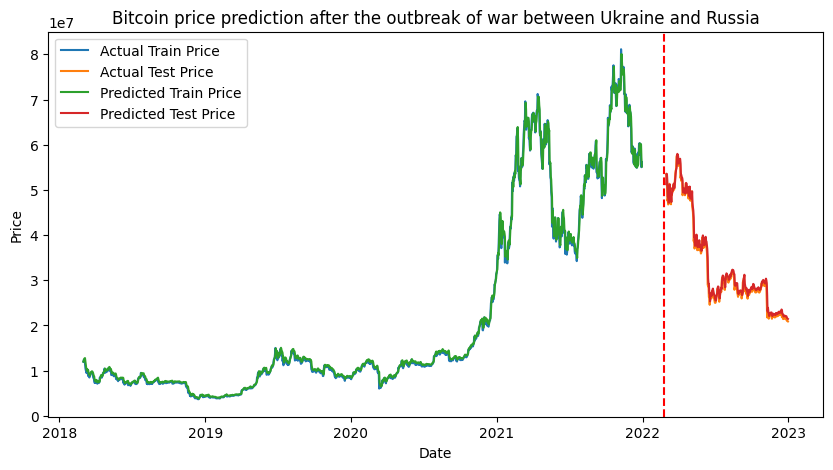

In [ ]:
# 예측 결과 시각화
train_predict_f = scaler_f.inverse_transform(train_predict_f)
test_predict_f = scaler_f.inverse_transform(test_predict_f)


# train_predict와 test_predict 배열에 NaN 값이 포함되어 있는지 확인하기 위해  np.isnan() 함수를 사용
# 만약 NaN 값이 있다면, 이를 np.ma.array() 함수를 사용하여 NaN 값을 마스킹한 배열을 생성한다.
# np.ma.array()에서는 평균값을 구할수있다.(조건이 참일때 평균값을 구해서 NaN값으로 대체한다)

# train_predict와 test_predict 배열의 값을 scaler.inverse_transform() 함수를 사용하여 스케일링된 값을 원래의 값으로 복원합니다.

plt.figure(figsize=(10, 5))

# 2022년 2월 24일에 빨간색 세로축을 추가합니다.
target_date = datetime.datetime(2022, 2, 24)
plt.axvline(x=target_date, color='red', linestyle='--')

plt.plot(df_f[look_back:len(train_data_f)].index, df_f[look_back:len(train_data_f)].values, label='Actual Train Price')
plt.plot(df_f[len(train_data_f)+look_back:].index, df_f[len(train_data_f)+look_back:].values, label='Actual Test Price')
plt.plot(df_f[look_back:len(train_data_f)].index, train_predict_f, label='Predicted Train Price')
plt.plot(df_f[len(train_data_f)+look_back:].index, test_predict_f, label='Predicted Test Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin price prediction after the outbreak of war between Ukraine and Russia')
plt.legend()
plt.show()

In [ ]:
# train 및 test 데이터에 대한 예측값 생성
train_predict_f = model_f.predict(x_train_f)
test_predict_f = model_f.predict(x_test_f)

# 스케일링 된 값을 다시 원래 값으로 변환
train_predict_f = scaler_f.inverse_transform(train_predict_f)  #inverse_transform() 함수를 이용해 원본값으로 복원가능하다
y_train_f = scaler_f.inverse_transform([y_train_f])
test_predict_f = scaler_f.inverse_transform(test_predict_f)
y_test_f = scaler_f.inverse_transform([y_test_f])


train_r2_score_f= r2_score(y_train_f[0], train_predict_f[:,0])
test_r2_score_f = r2_score(y_test_f[0], test_predict_f[:,0])


# 결과 출력
print("Train R2 Score : ", train_r2_score_f)  # train 데이터의 정확도를 알려준다
print("Test R2 Score : ", test_r2_score_f)    # test 데이터의 정확도를 알려준다

10/10 [==============================] - 0s 8ms/step
Train R2 Score :  0.996361774794338
Test R2 Score :  0.9869057204875414
